In [ ]:
from __future__ import division

import os
import glob
from collections import defaultdict, Counter
import colorsys

import imageio
import numpy as np
from sklearn.cluster import KMeans

import matplotlib as mpl
from matplotlib import pyplot as plt

from evaluation.bbox_iou import bbox_iou

In [2]:
def size(mask, bbox):
    tly, tlx, bry, brx = bbox
    return np.count_nonzero(mask[tly:bry,tlx:brx])

In [3]:
def form_factor(bbox):
    tly, tlx, bry, brx = bbox
    width = brx - tlx
    height = bry - tly
    return width / height

In [4]:
def filling_ratio(mask, bbox):
    tly, tlx, bry, brx = bbox
    width = brx - tlx
    height = bry - tly
    bbox_area = width * height
    mask_area = size(mask, bbox)
    return mask_area / bbox_area

In [5]:
def compute_num_overlap(gts):
    if len(gts) > 1:
        for i in range(len(gts)):
            bboxA = list(map(float, gts[i][:4]))
            for j in range(i+1, len(gts)):
                bboxB = list(map(float, gts[j][:4]))
                print(img, bbox_iou(bboxA, bboxB))

In [6]:
def dominant_colors(img, mask, bbox, k=3, n=2):
    tly, tlx, bry, brx = bbox
    
    img_patch = img[tly:bry,tlx:brx]
    mask_patch = mask[tly:bry,tlx:brx]
    mask_patch = np.repeat(mask_patch[:,:,np.newaxis], 3, axis=2)
    pixels = img_patch[np.nonzero(mask_patch)].reshape((-1, 3))
    
    clt = KMeans(n_clusters=k)
    labels = clt.fit_predict(pixels)
    
    c = Counter(labels)
    most_common, _ = zip(*c.most_common(n))
    most_common = list(most_common)
    
    return clt.cluster_centers_[most_common].astype(np.uint8)

In [7]:
def show_colors(colors):
    fig = plt.figure(figsize=(6, 1), frameon=False)
    ax = fig.add_subplot(111)
    for x, color in enumerate(colors):
        ax.add_patch(mpl.patches.Rectangle((x, 0), 1, 1, facecolor=color))
    ax.set_xlim((0, len(colors)))
    ax.set_ylim((0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")

In [8]:
def show_patch(img, mask, bbox):
    fig = plt.figure(figsize=(6, 1), frameon=False)
    tly, tlx, bry, brx = bbox
    img_patch = img[tly:bry,tlx:brx]
    mask_patch = mask[tly:bry,tlx:brx]
    mask_patch = np.minimum(mask_patch, 1)
    mask_patch = np.repeat(mask_patch[:,:,np.newaxis], 3, axis=2)
    plt.imshow(img_patch * mask_patch)

In [9]:
class_frequency = defaultdict(int)
size_per_class = defaultdict(list)
form_factor_per_class = defaultdict(list)
filling_ratio_per_class = defaultdict(list)
rgb_colors_per_class = defaultdict(list)
for img_file in sorted(glob.glob('data/train/*.jpg')):
    name = os.path.splitext(os.path.split(img_file)[1])[0]
    mask_file = 'data/train/mask/mask.{}.png'.format(name)
    gt_file = 'data/train/gt/gt.{}.txt'.format(name)
    img = imageio.imread(img_file)
    mask = imageio.imread(mask_file)
    gts = [line.split(' ') for line in open(gt_file, 'r').read().splitlines()]
    for gt in gts:
        bbox = np.round(list(map(int, map(float, gt[:4]))))
        label = gt[4]
        
        class_frequency[label] += 1
        size_per_class[label].append(size(mask, bbox))
        form_factor_per_class[label].append(form_factor(bbox))
        filling_ratio_per_class[label].append(filling_ratio(mask, bbox))
        rgb_colors_per_class[label].extend(dominant_colors(img, mask, bbox))

In [10]:
hsv_colors_per_class = defaultdict(list)
for label in rgb_colors_per_class.keys():
    for rgb in rgb_colors_per_class[label]:
        hsv = list(colorsys.rgb_to_hsv(*(rgb/255)))
        hsv[2] = 1  # maximum amount of white
        hsv_colors_per_class[label].append(hsv)

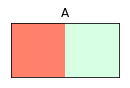

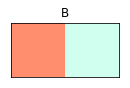

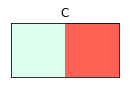

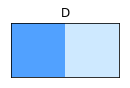

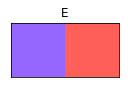

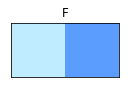

In [ ]:
for label in sorted(hsv_colors_per_class.keys()):
    hsv_colors = hsv_colors_per_class[label]
    clt = KMeans(n_clusters=2)
    clt.fit(hsv_colors)
    avg_colors = clt.cluster_centers_
    show_colors([colorsys.hsv_to_rgb(*hsv) for hsv in avg_colors])
    plt.title(label)
plt.show()

(0.6212, 0.6416, 1.0000)
(0.0196, 0.6111, 1.0000)
(0.4834, 0.1865, 1.0000)


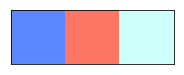

In [12]:
hsv_colors = np.concatenate(list(hsv_colors_per_class.values()))
clt = KMeans(n_clusters=3)  # 3 colors
clt.fit(hsv_colors)
avg_colors = clt.cluster_centers_
[print('({:.4f}, {:.4f}, {:.4f})'.format(*c)) for c in avg_colors]
show_colors([colorsys.hsv_to_rgb(*hsv) for hsv in avg_colors])
plt.show()